# Dataset

This project uses the mini MIAS dataset, publicly available at [http://peipa.essex.ac.uk/info/mias.html]. 

The images are in the `mias_data` subdirectory of this repository. 

There are two files for each participant. The images have been padded and resized as necessary to all have (1024, 1024) shape. 

The `read_mias` function will return a `numpy.array` with 322 (1024, 1024) images. In the stack of images the odd numbered indexes are for the right mammograms and the even numbered indexes are for the left mammograms. 

In [1]:
from read_mias import *
from denoise import *
from orient import *
from rm_pec import *
from find_points import *
from rotations import *
import matplotlib.pyplot as plt
import cv2 as cv

path = 'mias_data'
data = read_mias(path)

In [3]:
print(data.shape)

(322, 1024, 1024)


[]

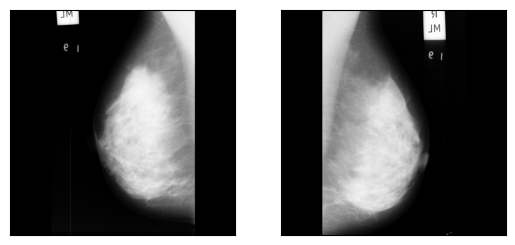

In [2]:
fig, axs = plt.subplots(1,2)
axs[0].imshow(data[2], cmap ='gray')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(data[3],cmap = 'gray')
axs[1].set_xticks([])
axs[1].set_yticks([])

## Mammogram Orientation



[]

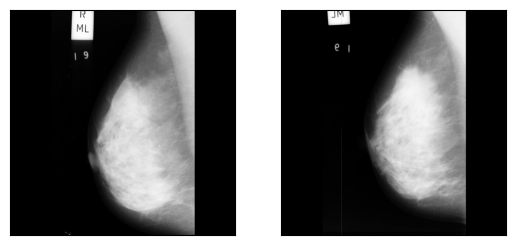

In [3]:
oriented = reorient_all(data)

fig, axs = plt.subplots(1,2)
axs[0].imshow(oriented[3], cmap ='gray')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].imshow(oriented[2],cmap = 'gray')
axs[1].set_xticks([])
axs[1].set_yticks([])

## Omit Noise and Artifacts

In [4]:
denoised = denoise_all(oriented)

[]

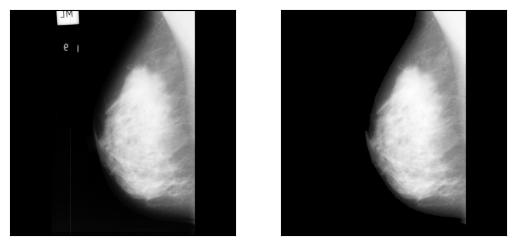

In [5]:
idx = 2
fig, axs = plt.subplots(1,2)
axs[0].imshow(oriented[idx],cmap = 'gray')
axs[1].imshow(denoised[idx], cmap = 'gray')
axs[0].set_xticks([])
axs[0].set_yticks([])
axs[1].set_xticks([])
axs[1].set_yticks([])

## Pectoral Muscle Removal 

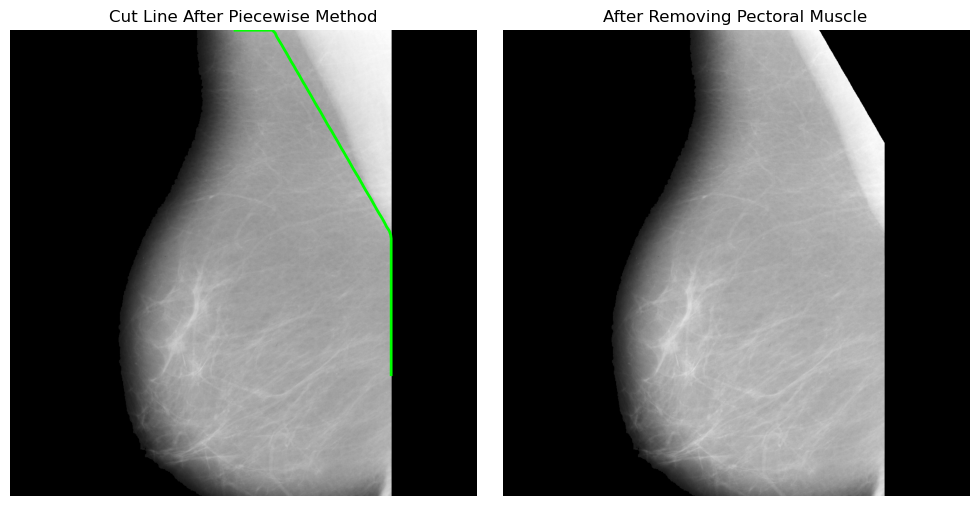

In [7]:
idx = 5
removed, cutline = remove_pectoral_muscle(denoised[idx],background_thresh = 10, segment_count=100)

fig, axs = plt.subplots(1, 2, figsize=(10, 5))

axs[0].imshow(denoised[idx], cmap='gray')
axs[0].plot(cutline[:, 0], cutline[:, 1], color='lime', linewidth=2)
axs[0].set_title("Cut Line After Piecewise Method")
axs[0].axis('off')

axs[1].imshow(removed, cmap='gray')
axs[1].set_title("After Removing Pectoral Muscle")
axs[1].axis('off')

plt.tight_layout()
plt.show()


In [8]:
left_img = denoised[254]
right_img = denoised[255]

pectoral_removed_left, cutline_left = remove_pectoral_muscle(left_img)
pectoral_removed_right, cutline_right = remove_pectoral_muscle(right_img)


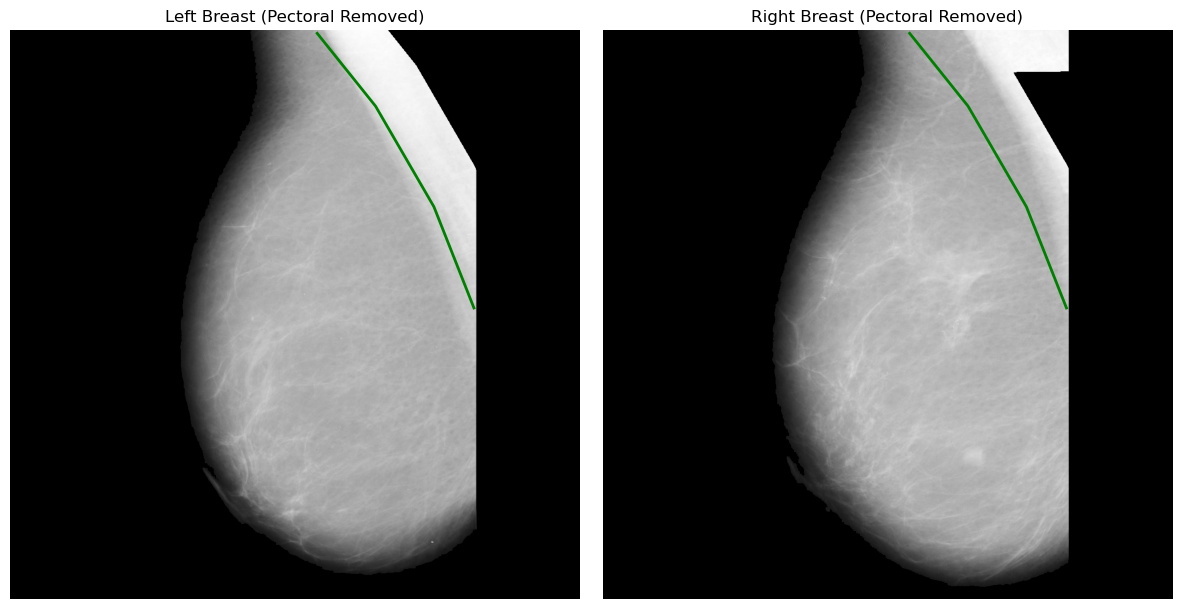

In [9]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(pectoral_removed_left, cmap='gray')
axs[0].plot(cutline_left[:, 0], cutline_left[:, 1], 'g-', linewidth=2)
axs[0].set_title("Left Breast (Pectoral Removed)")
axs[0].axis('off')

axs[1].imshow(pectoral_removed_right, cmap='gray')
axs[1].plot(cutline_right[:, 0], cutline_right[:, 1], 'g-', linewidth=2)
axs[1].set_title("Right Breast (Pectoral Removed)")
axs[1].axis('off')

plt.tight_layout()
plt.show()



## Mammogram Allignment

In [15]:
idx = 254  
img = denoised[idx]  
cp = compute_cp(img)
print("Cp (centroid):", cp)


Cp (centroid): (622, 459)


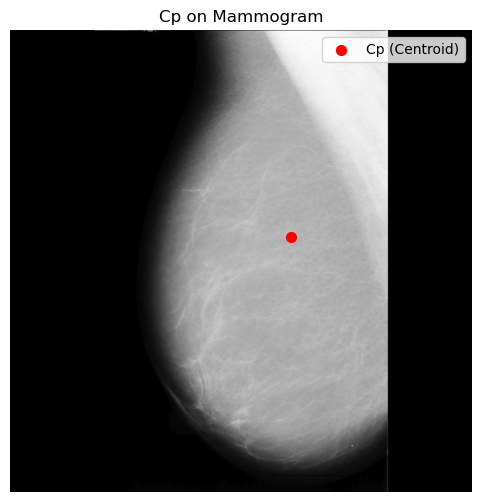

In [16]:
plt.figure(figsize=(8, 6))
plt.imshow(img, cmap='gray')
plt.scatter(*cp, color='red', s=50, label='Cp (Centroid)')
plt.title("Cp on Mammogram")
plt.legend()
plt.axis('off')
plt.show()


Np (nipple point): (398, 870)


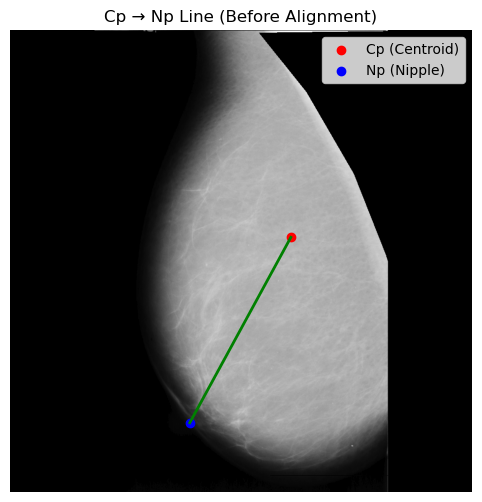

In [18]:
np_point = compute_np_left(img)
print("Np (nipple point):", np_point)
img = removed  


plt.figure(figsize=(8, 6))
plt.imshow(img, cmap='gray')
plt.scatter(*cp, color='red', label='Cp (Centroid)')
plt.scatter(*np_point, color='blue', label='Np (Nipple)')
plt.plot([cp[0], np_point[0]], [cp[1], np_point[1]], 'g-', linewidth=2)
plt.title("Cp → Np Line (Before Alignment)")
plt.axis('off')
plt.legend()
plt.show()


In [19]:
np_right = compute_np_left(pectoral_removed_right)


In [38]:
cp_right = compute_cp(pectoral_removed_right)
np_right = compute_np_left(pectoral_removed_right)  
theta_right = compute_alignment_angle(cp_right, np_right)
aligned_right = rotate_image_about_cp_square(pectoral_removed_right, cp_right, -theta_right)


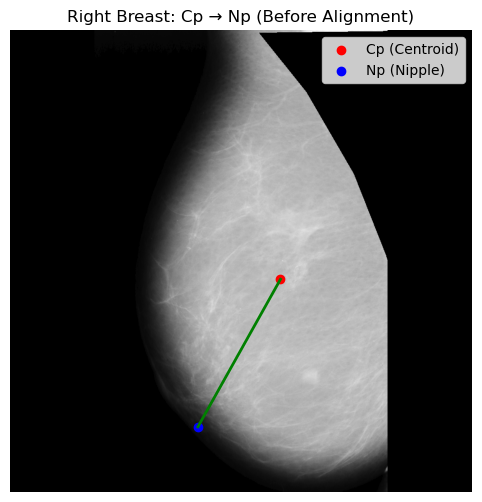

In [39]:
plt.figure(figsize=(8, 6))
plt.imshow(pectoral_removed_right, cmap='gray')
plt.scatter(*cp_right, color='red', label='Cp (Centroid)')
plt.scatter(*np_right, color='blue', label='Np (Nipple)')
plt.plot([cp_right[0], np_right[0]], [cp_right[1], np_right[1]], 'g-', linewidth=2)
plt.title("Right Breast: Cp → Np (Before Alignment)")
plt.axis('off')
plt.legend()
plt.show()


## TRANSLATION & ROTATION 

In [40]:
theta = compute_alignment_angle(cp, np_point)
print("Rotation angle (degrees):", theta)


Rotation angle (degrees): -61.40907853600997


In [ ]:
import numpy as np
import cv2
import matplotlib.pyplot as plt


In [44]:

# LEFT
cp_left = compute_cp(pectoral_removed_left)
np_left = compute_np_left(pectoral_removed_left)
theta_left = compute_alignment_angle(cp_left, np_left)
aligned_left, cp_sq_left = rotate_image_about_cp_square(pectoral_removed_left, cp_left, -theta_left)

# RIGHT
cp_right = compute_cp(pectoral_removed_right)
np_right = compute_np_left(pectoral_removed_right)
theta_right = compute_alignment_angle(cp_right, np_right)
aligned_left, cp_sq_left = rotate_image_about_cp_square(pectoral_removed_left, cp_left, theta_left)


In [42]:
aligned_left, _ = rotate_image_about_cp_square(pectoral_removed_left, cp_left, theta_left)
aligned_right, _ = rotate_image_about_cp_square(pectoral_removed_right, cp_right, theta_right)


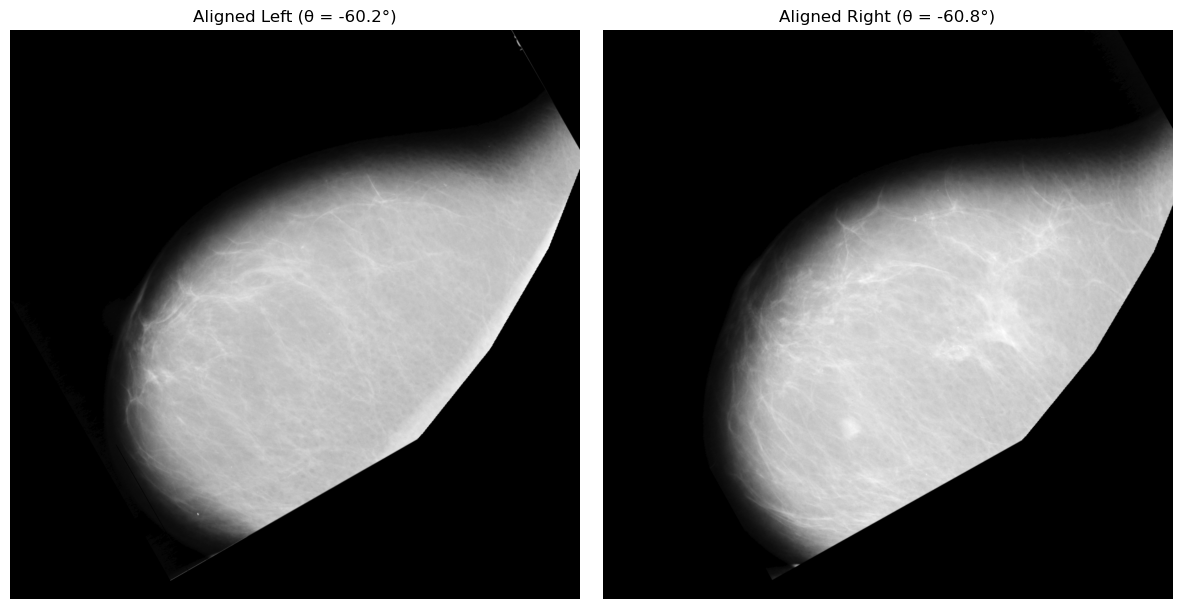

In [45]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(aligned_left, cmap='gray')
axs[0].set_title(f"Aligned Left (θ = {theta_left:.1f}°)")
axs[0].axis('off')

axs[1].imshow(aligned_right, cmap='gray')
axs[1].set_title(f"Aligned Right (θ = {theta_right:.1f}°)")
axs[1].axis('off')

plt.tight_layout()
plt.show()


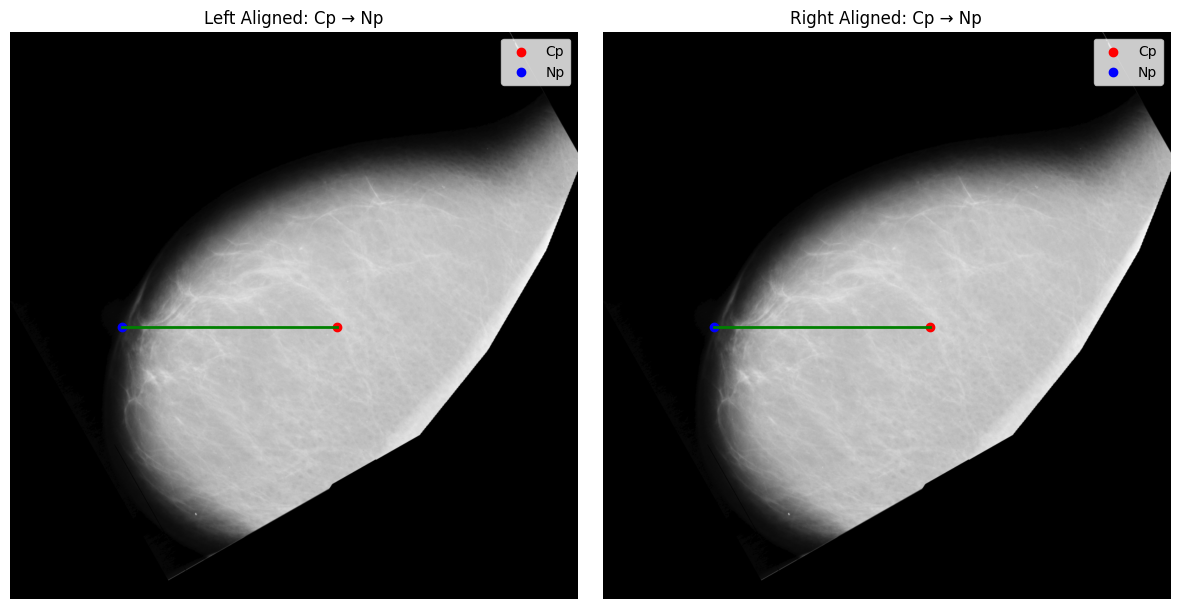

In [ ]:

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

# LEFT
axs[0].imshow(aligned_left, cmap='gray')
axs[0].scatter(*rot_cp_left, color='red', label='Cp')
axs[0].scatter(*rot_np_left, color='blue', label='Np')
axs[0].plot([rot_cp_left[0], rot_np_left[0]], [rot_cp_left[1], rot_np_left[1]], 'g-', linewidth=2)
axs[0].set_title("Left Aligned: Cp → Np")
axs[0].axis('off')
axs[0].legend()

# RIGHT
axs[1].imshow(aligned_right, cmap='gray')
axs[1].scatter(*rot_cp_right, color='red', label='Cp')
axs[1].scatter(*rot_np_right, color='blue', label='Np')
axs[1].plot([rot_cp_right[0], rot_np_right[0]], [rot_cp_right[1], rot_np_right[1]], 'g-', linewidth=2)
axs[1].set_title("Right Aligned: Cp → Np")
axs[1].axis('off')
axs[1].legend()

plt.tight_layout()
plt.show()


## REJECTING UNWANTED REGION

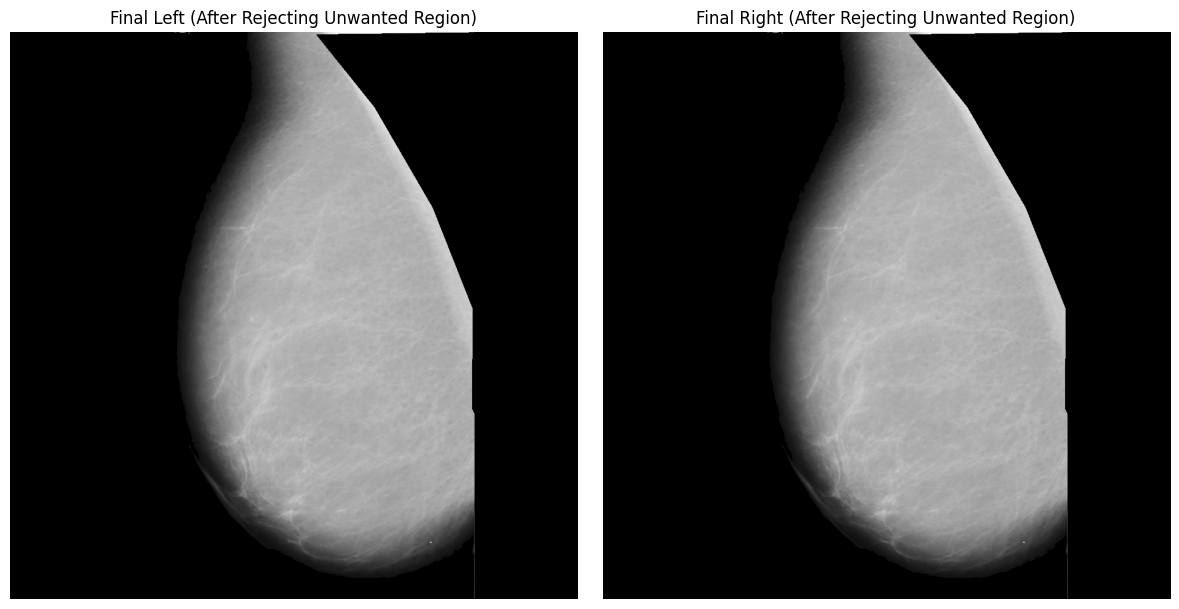

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def create_binary_mask(image, blur_kernel=(3, 3), threshold=15):
    blurred = cv2.blur(image, blur_kernel)
    _, binary_mask = cv2.threshold(blurred, threshold, 255, cv2.THRESH_BINARY)
    return binary_mask

mask_left = create_binary_mask(pectoral_removed_left)
mask_right = create_binary_mask(pectoral_removed_right)

M_align = cv2.bitwise_and(mask_left, mask_right)

final_left = cv2.bitwise_and(pectoral_removed_left, pectoral_removed_left, mask=M_align)
final_right = cv2.bitwise_and(pectoral_removed_right, pectoral_removed_right, mask=M_align)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(final_left, cmap='gray')
axs[0].set_title("Final Left (After Rejecting Unwanted Region)")
axs[0].axis('off')

axs[1].imshow(final_right, cmap='gray')
axs[1].set_title("Final Right (After Rejecting Unwanted Region)")
axs[1].axis('off')

plt.tight_layout()
plt.show()


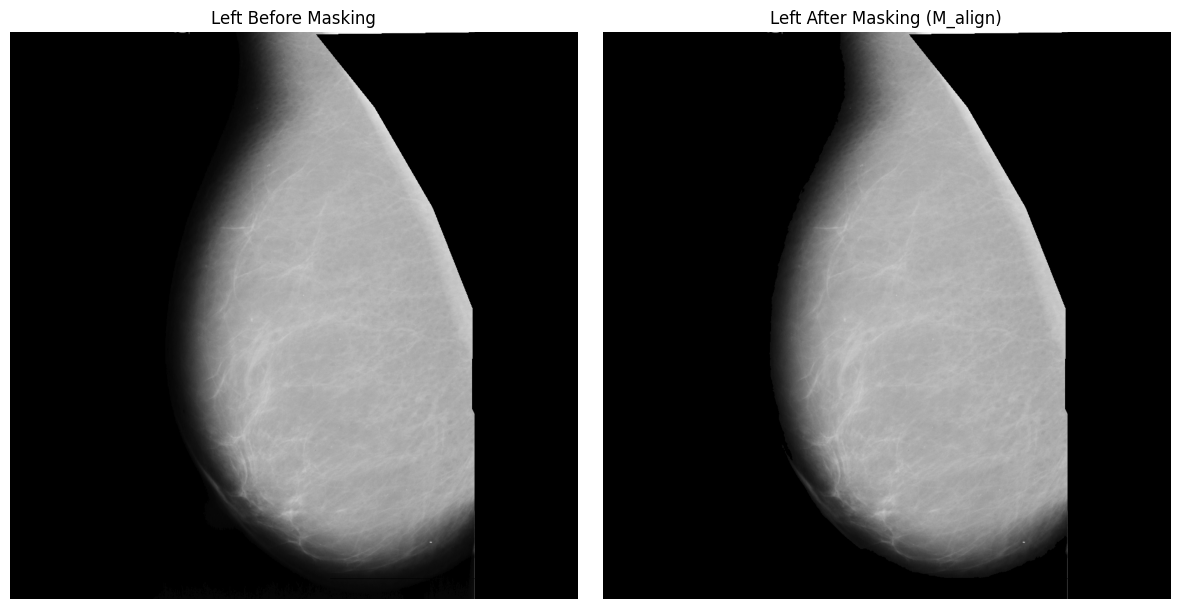

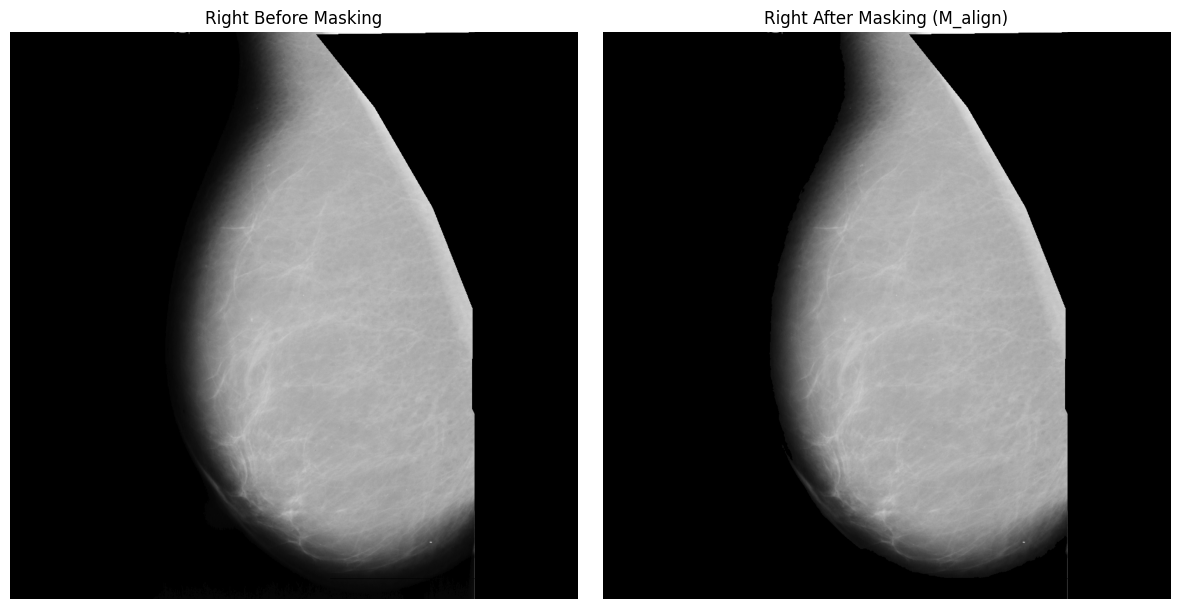

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(pectoral_removed_left, cmap='gray')
axs[0].set_title("Left Before Masking")
axs[0].axis('off')

axs[1].imshow(final_left, cmap='gray')
axs[1].set_title("Left After Masking (M_align)")
axs[1].axis('off')
plt.tight_layout()
plt.show()

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(pectoral_removed_right, cmap='gray')
axs[0].set_title("Right Before Masking")
axs[0].axis('off')

axs[1].imshow(final_right, cmap='gray')
axs[1].set_title("Right After Masking (M_align)")
axs[1].axis('off')
plt.tight_layout()
plt.show()


In [189]:
pectoral_removed_left = [remove_pectoral_muscle(img) for img in denoised]


In [ ]:
pectoral_removed_left, _ = remove_pectoral_muscle(denoised[254]) 
final_left = cv2.bitwise_and(pectoral_removed_left, pectoral_removed_left, mask=M_align)


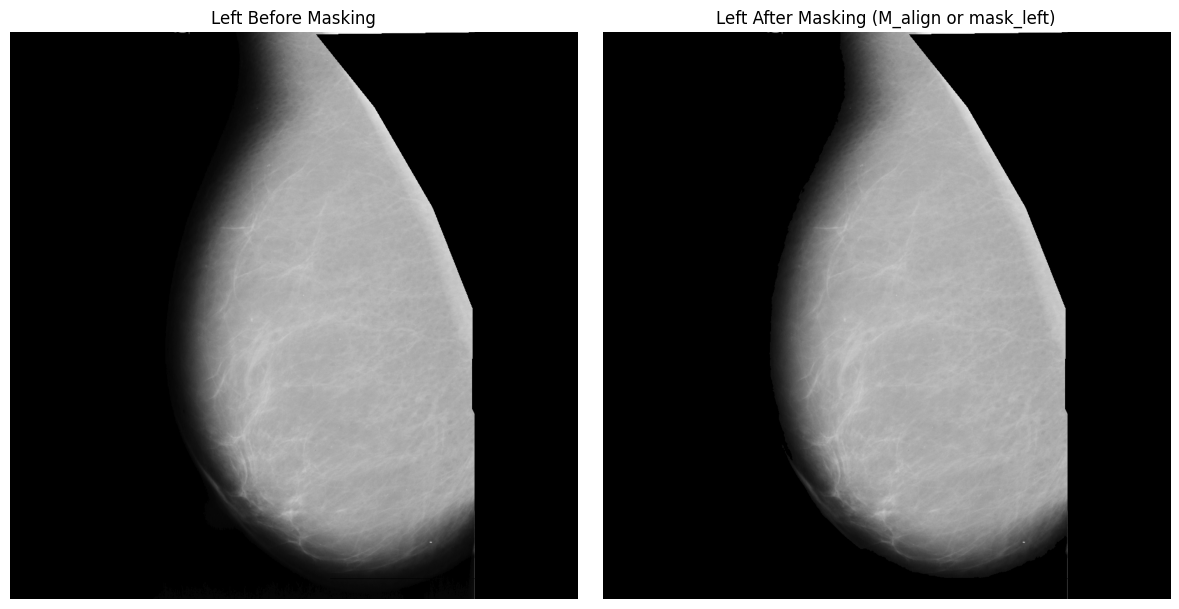

In [ ]:

left_img = denoised[254]
pectoral_removed_left, _ = remove_pectoral_muscle(left_img)
mask_left = create_binary_mask(pectoral_removed_left)
final_left = cv2.bitwise_and(pectoral_removed_left, pectoral_removed_left, mask=mask_left)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))

axs[0].imshow(pectoral_removed_left, cmap='gray')
axs[0].set_title("Left Before Masking")
axs[0].axis('off')

axs[1].imshow(final_left, cmap='gray')
axs[1].set_title("Left After Masking (M_align or mask_left)")
axs[1].axis('off')

plt.tight_layout()
plt.show()


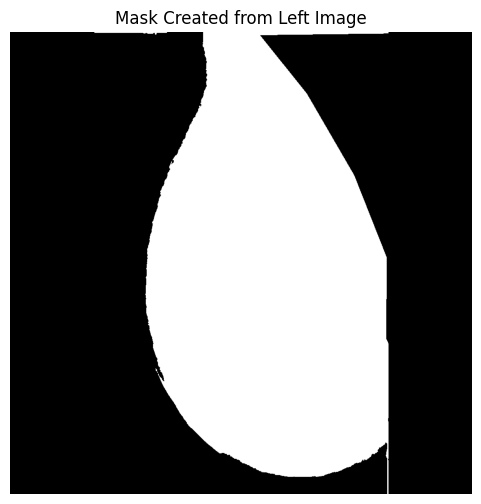

In [204]:
plt.figure(figsize=(6, 6))
plt.imshow(mask_left, cmap='gray')
plt.title("Mask Created from Left Image")
plt.axis('off')
plt.show()


In [ ]:
M_align = cv2.bitwise_and(mask_left, mask_right)

final_left = cv2.bitwise_and(pectoral_removed_left, pectoral_removed_left, mask=M_align)
final_right = cv2.bitwise_and(pectoral_removed_right, pectoral_removed_right, mask=M_align)


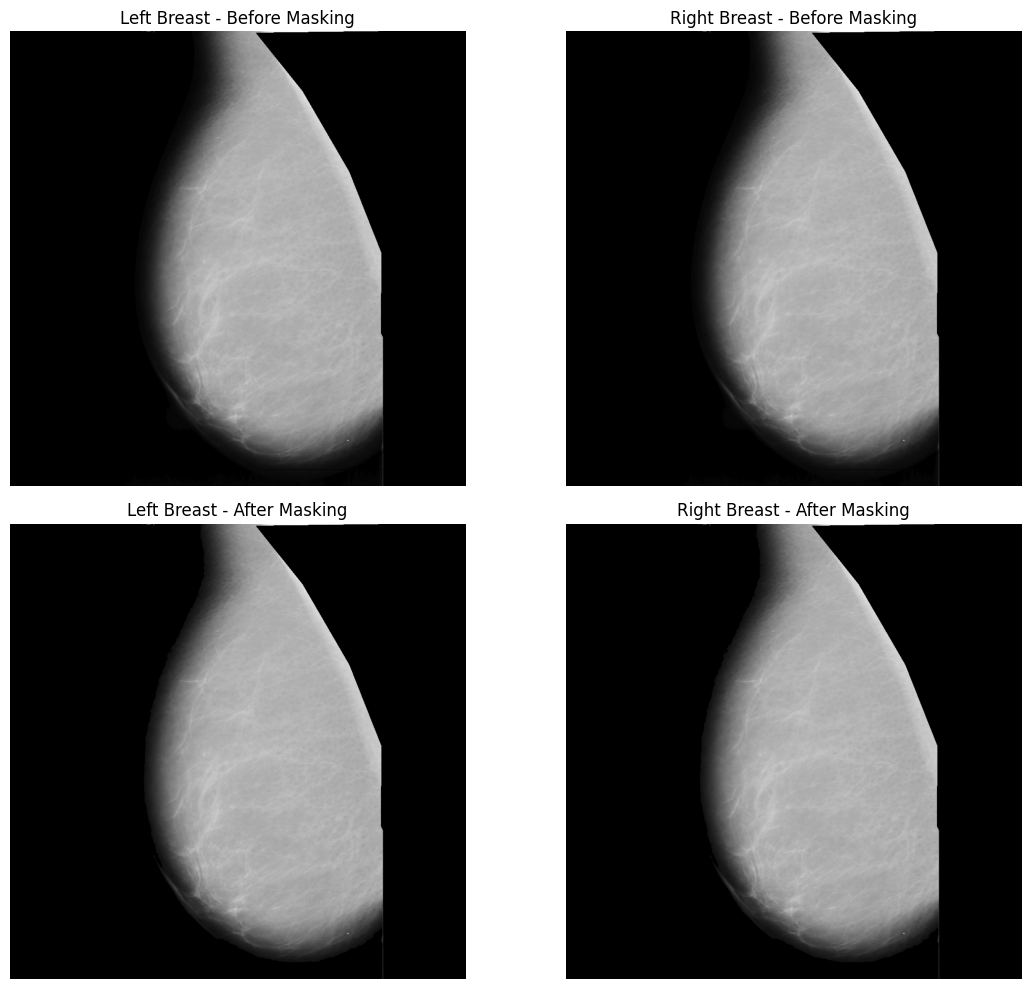

In [206]:
fig, axs = plt.subplots(2, 2, figsize=(12, 10))

# Left Breast
axs[0, 0].imshow(pectoral_removed_left, cmap='gray')
axs[0, 0].set_title("Left Breast - Before Masking")
axs[0, 0].axis('off')

axs[1, 0].imshow(final_left, cmap='gray')
axs[1, 0].set_title("Left Breast - After Masking")
axs[1, 0].axis('off')

# Right Breast
axs[0, 1].imshow(pectoral_removed_right, cmap='gray')
axs[0, 1].set_title("Right Breast - Before Masking")
axs[0, 1].axis('off')

axs[1, 1].imshow(final_right, cmap='gray')
axs[1, 1].set_title("Right Breast - After Masking")
axs[1, 1].axis('off')

plt.tight_layout()
plt.show()


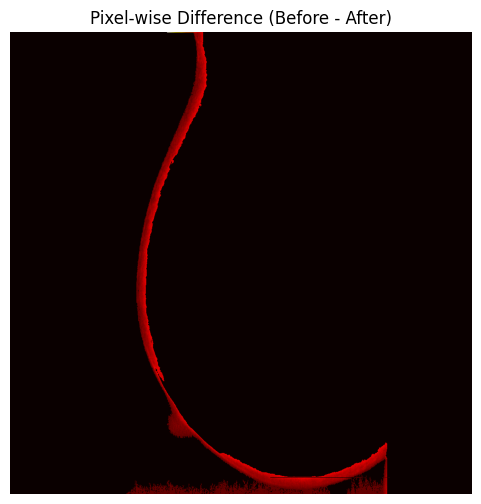

In [207]:
difference = cv2.absdiff(pectoral_removed_left, final_left)

plt.figure(figsize=(6, 6))
plt.imshow(difference, cmap='hot')
plt.title("Pixel-wise Difference (Before - After)")
plt.axis('off')
plt.show()


In [ ]:
def crop_to_mask(image, mask):
    
    ys, xs = np.where(mask > 0)
    if len(xs) == 0 or len(ys) == 0:
        print("Warning: Mask is empty, returning original image.")
        return image 
    x_min, x_max = xs.min(), xs.max()
    y_min, y_max = ys.min(), ys.max()

    return image[y_min:y_max+1, x_min:x_max+1]


In [213]:
final_left_cropped = crop_to_mask(final_left, M_align)
final_right_cropped = crop_to_mask(final_right, M_align)


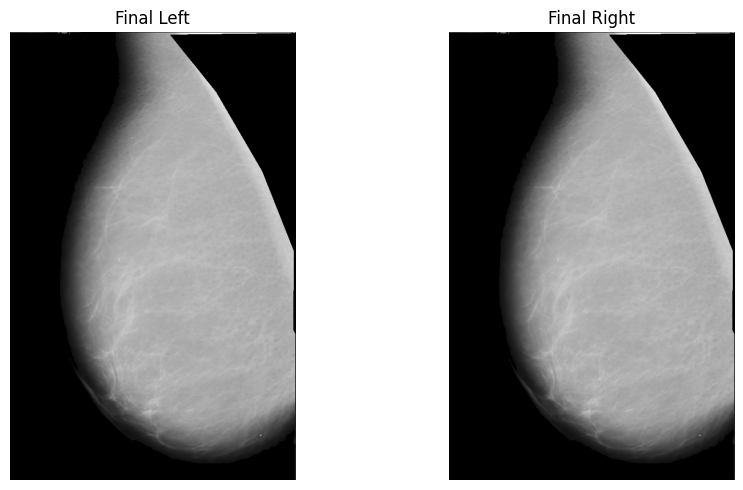

In [214]:
fig, axs = plt.subplots(1, 2, figsize=(10, 5))
axs[0].imshow(final_left_cropped, cmap='gray')
axs[0].set_title("Final Left")
axs[0].axis('off')

axs[1].imshow(final_right_cropped, cmap='gray')
axs[1].set_title("Final Right")
axs[1].axis('off')

plt.tight_layout()
plt.show()
